### Random forest

,param_max_depth,param_n_estimators,mean_train_score,mean_test_score
0,5,200,0.927079,0.853295
1,5,500,0.927101,0.854797
2,6,200,0.956083,0.861312
3,6,500,0.957229,0.863910
4,7,200,0.978749,0.868989
5,7,500,0.979698,0.870806
6,8,200,0.992826,0.876125
7,8,500,0.993180,0.878803


Best model: # 7
   -> Tree depth:  8
   -> Tree count:  500
   -> Out-of-sample AUC:  0.861843020022247


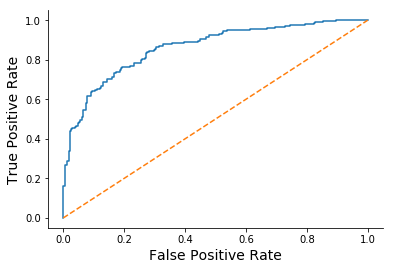

In [23]:
# ==================       
# =  << Config >>  =         
# ==================    
binary_target = True #(RandomForestClassifier/RandomForestRegressor)
file_name = 'source/WineDataBinary.xlsx'
y_formula = 'quality ~ .'
tree_depth = [5, 6, 7, 8]
tree_count = [200, 500]
eval_size = 0.3
seed = 123

# =====================         
# =  Import Packages  =         
# =====================              
import pandas as pd # Data processing          
import patsy as pt # Data processing  
import numpy as np # Math                 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # Modelling code
from sklearn import model_selection # Cross validation
from sklearn import metrics # Evaluation metrics
import matplotlib.pyplot as plt # Plotting code
import seaborn as sns # Plotting code

# ==============================          
# =  Matrix builder functions  = 
# ==============================          
def create_train_matrices(train_data, formula): 
# IN:  - Train data
#      - Formula string of the model
# OUT: - Dictionary with:
#          -> y: array with variable to predict
#          -> X: array with all independent variables
#          -> design_info: dict. with y_col and x_cols key, values are the name of the columns
     
    # If "y~." then we add all the variables manually
    if formula.split('~')[1].strip() == '.':    
        y_col = formula.split('~')[0].strip()   
        x_cols = [i for i in train_data.columns if i != y_col]  
        return { 'y' : train_data[y_col],       
                 'X' : train_data[x_cols],      
                 'design_info' : {'y_col' : y_col, 'x_cols' : x_cols} }         
    else: # Patsy generates the columns based on the string                       
        train_matrices = pt.dmatrices(formula, train_data, NA_action = 'raise')                      
        return {'y' : pd.DataFrame(train_matrices[0].transpose()[0]), # 'y' values transposed because Patsy delivers opposite to what sklearn expects
                'X' : pd.DataFrame(train_matrices[1]),            
                'design_info' : { 'y' : train_matrices[0].design_info,              
                                  'X' : train_matrices[1].design_info } }

def create_eval_matrices(eval_data, design_info): 
# IN:  - Evaluation data
#      - Design info (output from create_train_matrices)
# OUT: - Dictionary with:
#          -> y: array with variable to predict
#          -> X: array with all independent variables
     
    # Check design_info is ok
    if 'y_col' in design_info:
        return {'X' : eval_data[design_info['x_cols']],          
                'y' : eval_data[design_info['y_col']] }          
    else: # Create the new matrices.
        out = {}         
        for i in ['X', 'y']:        
            out[i] = pt.build_design_matrices([design_info[i]],     
                                                eval_data,           
                                                NA_action = 'raise')[0]             
        # Transpose the 'y' values  
        out['y'] = out['y'].transpose()[0]          
        return out

# ===============================            
# =  Load and Prepare the Data  =               
# ===============================  
# Load the training data        
all_data = pd.read_excel(file_name)

# Split into train and evaluation (random_state MUST be the same as used for the text mining)
training_data, evaluation_data = model_selection.train_test_split(
                                 all_data,
                                 train_size = 1 - eval_size,
                                 test_size = eval_size,
                                 shuffle = True,
                                 random_state = seed)

# Create the data matrices
train_matrices = create_train_matrices(training_data, y_formula)
evaluation_matrices = create_eval_matrices(evaluation_data, train_matrices['design_info'])

# ======================                
# =  Cross Validation  =        
# ======================        
# List of models to test (key = param name, value = list of values to try)         
param_grid = {'max_depth': tree_depth, 'n_estimators': tree_count,}

# Creation of CV using GridSearchCV
RF = RandomForestClassifier if binary_target else RandomForestRegressor
models = model_selection.GridSearchCV(estimator = RF(random_state = seed),
                                      param_grid = param_grid,
                                      scoring = 'roc_auc' if binary_target else 'r2',
                                      cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = seed),
                                      refit = True, # Fit best model on all data
                                      return_train_score = True )

# Fit each model
models.fit(X = train_matrices['X'], y = train_matrices['y'])

# Retrieve the best model (this will have been re-trained on the full training data)
final_model = models.best_estimator_

# ==================     
# =   Evaluation   =            
# ==================            

# Get predictions using the final model
if binary_target:
    evaluation_preds = [i[1] for i in final_model.predict_proba(evaluation_matrices['X'])]
else:
    evaluation_preds = final_model.predict(evaluation_matrices['X'])

# Get the score on these data
if binary_target:
    AUC = metrics.roc_auc_score(evaluation_matrices['y'], evaluation_preds)
    GINI = (AUC-0.5)/0.5
    fpr, tpr, _ = metrics.roc_curve(evaluation_matrices['y'], evaluation_preds) #(_ discards last function output)
else:
    R2 = metrics.r2_score(evaluation_matrices['y'], evaluation_preds)

# =======================    
# =   Display results   =            
# =======================

# Cross validation test
display(pd.DataFrame(models.cv_results_)[['param_max_depth','param_n_estimators','mean_train_score','mean_test_score']])

# Best model picked
print("Best model: #", models.best_index_)
print("   -> Tree depth: ", final_model.max_depth)
print("   -> Tree count: ", final_model.n_estimators)
if binary_target:
    print("   -> Out-of-sample AUC: ", AUC)
    print("   -> Out-of-sample Gini: ", GINI)
else:
    print("   -> Out-of-sample R2: ", R2)

# Plot the ROC curve (binary only)
if binary_target:
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    sns.despine()
    plt.show()

# Full data to print to file or display
    # Predicted values: evaluation_preds
    # Real values: evaluation_matrices['y'].values
    # OrigRow (start at 0): evaluation_matrices['y'].keys()
